In [1]:
import tensorflow as tf

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices("GPU")))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)

Found GPU at: /device:GPU:0
Num GPUs Available:  1
2.9.1


In [3]:
from tensorflow.keras.regularizers import l2
#import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import pickle
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
np.set_printoptions(suppress=True)
from scipy.io import loadmat
import argparse
import json
import numpy as np
import os




from models import DeepConditionalModel
from inn_utils import (train_online_ml, compute_performance_metrics, train_online_kl, 
                       train_online_heteroscedastic, train_online_iaf)
from process_models import simulate_model_params, simulate_model, simulate_model_params, load_test_model
from viz import (plot_true_est_scatter, plot_true_est_posterior, 
                 plot_losses, plot_sbc, plot_performance_metrics, plot_contraction,
                 plot_true_est_posterior_samples)
import diagnostics as diag

In [4]:
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

In [5]:
%load_ext autoreload
%autoreload 2

# Conditional Invertible Neural Network (cINN)

## Summary network for the Ricker model
<p>We use an LSTM for the observed time-series data.</p>

In [6]:
class SequenceNetwork(tf.keras.Model):
    """
    Implements an LSTM summary network to summarize time-series data generated from the Ricker model.
    """
    
    def __init__(self, h_lstm_dim=32, h_dense_dim=64):
        super(SequenceNetwork, self).__init__()
        
        self.summary_part = tf.keras.Sequential([
            tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(h_lstm_dim)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
        ])
    
    def call(self, x, training=True):
        
        x = self.summary_part(x, training=training)
        return x

<p>We will also append a dummy noise parameter to the true parameter vector.</p>

In [7]:
def add_noise_var(X_batch, theta_batch):
    """
    Adds a column of uniform noise to the true parameter values.
    """
    
    noise_col = tf.random.uniform(shape=(theta_batch.shape[0], 1))
    theta_batch = tf.concat((theta_batch, noise_col), axis=-1)
    return X_batch, theta_batch

## Initialization 

In [8]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
train = False
param_names = [r'$\alpha$', r'$\beta$', r'$\Lambda$', r's',r'\Theta']
theta_dim = 5
global_step = tf.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 64
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 10
n_test = 300
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 2000
decay_rate = 0.1
clip_value = 5.
learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)
#earning_rate = tf.compat.v1.train.polynomial_decay(starter_learning_rate,global_step=tf.Variable(0, trainable=False), decay_steps=10000,end_learning_rate=0.5,power=0.5,cycle=False,name=None)

### Create test data

(64, 170)
(64, 5)
(64, 170)
(64, 5)


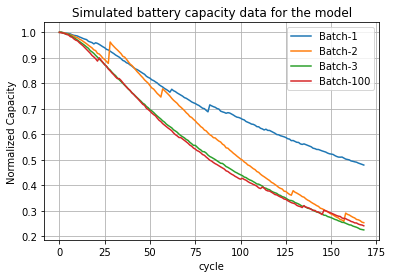

In [9]:
# For scatter
#simulate_model(100, n_points=500, to_tensor=False)
X_sim, theta_sim = simulate_model()
 
np.save('model_X.npy', X_sim)
np.save('model_theta.npy', theta_sim)

print(X_sim.shape)
print(theta_sim.shape)
X_test, theta_test = load_test_model()

print(X_test.shape)
print(theta_test.shape)

plt.plot(X_sim[0][1:],label='Batch-1')
plt.plot(X_sim[1][1:],label='Batch-2')
plt.plot(X_sim[2][1:],label='Batch-3')
'''plt.plot(X_sim[3][1:],label='Batch-4')
plt.plot(X_sim[4][1:],label='Batch-5')
plt.plot(X_sim[6][1:],label='Batch-6')'''
plt.plot(X_sim[63][1:],label='Batch-100')
plt.title("Simulated battery capacity data for the model")
plt.xlabel('cycle')
plt.ylabel('Normalized Capacity')
plt.legend()
plt.grid()
plt.show()

### Create networks

In [10]:
#summary_net = SequenceNetwork(h_lstm_dim=summary_dim)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=None, permute=True)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

### Plot performance of untrained networks

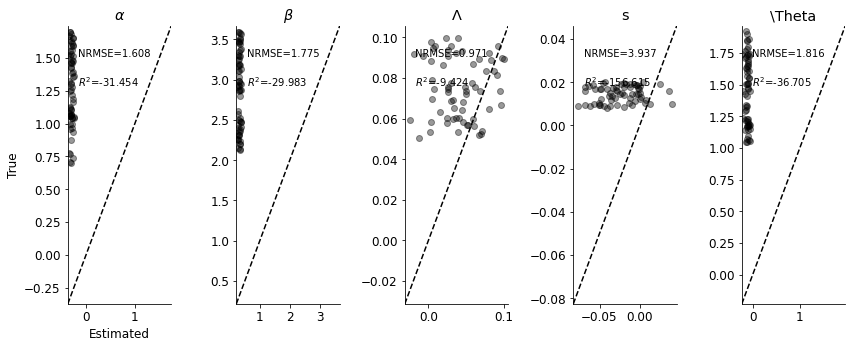

In [11]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names[:5], figsize=(12, 5))


### Checkpoint manager

In [12]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/model', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")


Restored from ./checkpoints/model\ckpt-230


## Train the model

In [13]:
%%time

for ep in range(1, epochs+1):
        with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
            losses = train_online_ml(model, optimizer, simulate_model, iterations_per_epoch, 
                                    batch_size, p_bar, clip_value=clip_value, 
                                    global_step=global_step, transform=add_noise_var)

            # Store checkpoint
            manager.save()
            

    
        
        

<timed exec>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Wall time: 11h 32min 26s


## Evaluate the trained model

### Posterior means (recovery)

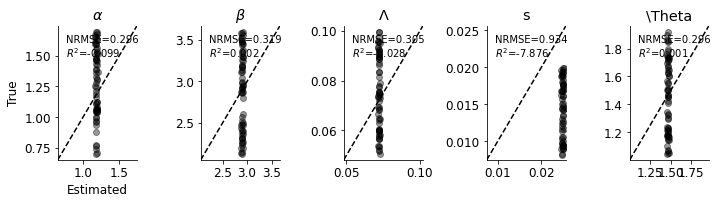

In [14]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names[:5], 
                      figsize=(10, 3), filename='Model')

Load the observed battery capacity data

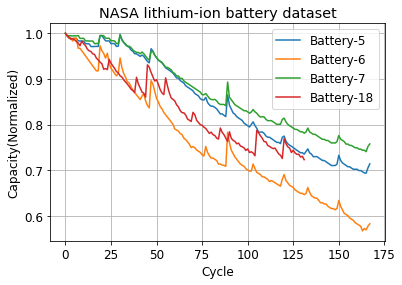

In [20]:
def load_battery(filename):
    # data is stored as a hierarchy of structs
    # we load with `squeeze_me` to simplify things a little
    data = loadmat(filename, squeeze_me=True)

    # the root variable is the name of the battery set
    # the next key is `cycle`
    # `squeeze_me` ends up with a 0-dim array somehow
    # so we index with and empty tuple to get the data
    events = data[list(data.keys())[-1]]["cycle"][()]

    # only the discharge events have the capacity data
    discharge_capacities = [
        e["data"]["Capacity"][()] for e in events if e["type"] == "discharge"
    ]

    # convert it back to an np.array
    discharge_capacities = np.array(discharge_capacities)
    # convert capacity to percentage
    discharge_capacities /= discharge_capacities[0]
    return discharge_capacities


filename1 = r"C:\Users\lra240\Desktop\2-Summer research 2022\6-Data\BatteryAgingARC-FY08Q4\B0005.mat"
filename2 = r"C:\Users\lra240\Desktop\2-Summer research 2022\6-Data\BatteryAgingARC-FY08Q4\B0006.mat"
filename3 = r"C:\Users\lra240\Desktop\2-Summer research 2022\6-Data\BatteryAgingARC-FY08Q4\B0007.mat"
filename4 = r"C:\Users\lra240\Desktop\2-Summer research 2022\6-Data\BatteryAgingARC-FY08Q4\B0018.mat"


data1 = load_battery(filename1)
data2 = load_battery(filename2)
data3 = load_battery(filename3)
data4 = load_battery(filename4)


plt.plot(data1, label='Battery-5')
plt.plot(data2, label='Battery-6')
plt.plot(data3, label='Battery-7')
plt.plot(data4, label='Battery-18')
plt.title("NASA lithium-ion battery dataset")
plt.xlabel('Cycle')
plt.ylabel('Capacity(Normalized)')
plt.legend()
plt.grid()
plt.show()


#tf.convert_to_tensor(X[:, :], dtype=tf.float32)

In [143]:
#Pedict the model:

#observed data converted to tensor
#data = tf.convert_to_tensor(data1, dtype=tf.float32)
data = torch.tensor(data1, dtype=torch.float64)
print(data)

#get the output smaples of posterior
p_aproximate = model.sample( data, n_samples = 1, to_numpy=True, training=False)
print(tf.shape(data))
print(p_aproximate)


tensor([1.0000, 0.9945, 0.9886, 0.9886, 0.9882, 0.9888, 0.9885, 0.9834, 0.9829,
        0.9828, 0.9828, 0.9772, 0.9770, 0.9768, 0.9710, 0.9707, 0.9710, 0.9712,
        0.9711, 0.9949, 0.9951, 0.9891, 0.9835, 0.9831, 0.9834, 0.9771, 0.9775,
        0.9771, 0.9711, 0.9718, 0.9975, 0.9861, 0.9803, 0.9746, 0.9721, 0.9692,
        0.9633, 0.9604, 0.9550, 0.9550, 0.9523, 0.9493, 0.9521, 0.9495, 0.9436,
        0.9383, 0.9351, 0.9661, 0.9605, 0.9520, 0.9464, 0.9410, 0.9382, 0.9353,
        0.9299, 0.9242, 0.9214, 0.9189, 0.9159, 0.9128, 0.9076, 0.9020, 0.9020,
        0.8962, 0.8936, 0.8909, 0.8848, 0.8822, 0.8795, 0.8768, 0.8738, 0.8679,
        0.8654, 0.8627, 0.8567, 0.8542, 0.8537, 0.8594, 0.8482, 0.8429, 0.8402,
        0.8400, 0.8374, 0.8343, 0.8286, 0.8230, 0.8233, 0.8202, 0.8174, 0.8650,
        0.8424, 0.8339, 0.8254, 0.8225, 0.8171, 0.8144, 0.8115, 0.8088, 0.8030,
        0.8004, 0.7974, 0.7946, 0.8004, 0.8059, 0.7976, 0.7917, 0.7831, 0.7833,
        0.7838, 0.7805, 0.7749, 0.7721, 

In [128]:
#test code C
'''
predRange = np.arange(101,168,1)
print(predRange)

state_history = torch.zeros((len(predRange),))
print(state_history)
measurement_history = torch.zeros((len(predRange),))
print(measurement_history)


print(round(1 / 0.012))
print(1 / 0.012)
'''


i = 10

print(p_aproximate[:,i,2])

param_a = torch.tensor(p_aproximate[:,i,0], dtype=torch.float64)
print(param_a)
poisson_rate = torch.tensor(p_aproximate[:,i,2], dtype=torch.float64)
print(poisson_rate)

[0.07920344]
tensor([1.4634], dtype=torch.float64)
tensor([0.0792], dtype=torch.float64)


In [35]:
import argparse
import json
import numpy as np
import os
import pyro
import pyro.distributions as dist
import torch
from dataset import load_battery
import time


<class 'numpy.ndarray'>


In [151]:
#test code C

import argparse
import json
import numpy as np
import os
import pyro
import pyro.distributions as dist
import torch
from dataset import load_battery
import time

# title MCMC Batch Training w/ Regen
pyro.set_rng_seed(1)


def model_predict(data,N_est,p_aproximate,noise_std):
            
  
    #length = len(data)-N_est # N_est - The point where the predication starts 101
    predRange = np.arange(101,168,1)
    state_history = torch.zeros((len(predRange),))
    measurement_history = torch.zeros((len(predRange),))
    
    for i in predRange:        
        param_a = torch.tensor(p_aproximate[:,i,0], dtype=torch.float64)
        param_b = torch.tensor(p_aproximate[:,i,1], dtype=torch.float64)
        poisson_rate = torch.tensor(p_aproximate[:,i,2], dtype=torch.float64)
        #poisson_rate_int = poisson_rate.item()
        regen_gamma_beta = torch.tensor(p_aproximate[:,i,3], dtype=torch.float64)
        regen_gamma_mu = torch.tensor(p_aproximate[:,i,4], dtype=torch.float64)
        Ri = np.random.gamma(regen_gamma_beta.item(), regen_gamma_mu.item())
        
        if i == 0:
            x_prediction = torch.tensor(1.0)
        elif i % round(1 / poisson_rate) == 0:
            x_prediction = (state_history[i - 1]- (param_a * param_b * i) / (10000 + (param_b * i) ** 2) + Ri)
        else:
            x_prediction = state_history[i - 1] - (param_a * param_b * i) / (10000 + (param_b * i) ** 2)
            
        next_observed = pyro.sample(f"meas_{i}", dist.Normal(x_prediction, torch.tensor(noise_std)))

        state_history[i] = x_prediction
        measurement_history[i] = next_observed
            
        return state_history,measurement_history

In [149]:
#test code C
state_history,measurement_history = model_predict(data, 100, p_aproximate, 0.001)
print(tf.shape(state_history))
print(measurement_history)
plt.plot(state_history)
plt.plot(measurement_history)

TypeError: type Tensor doesn't define __round__ method

In [137]:
import argparse
import json
import numpy as np
import os
import pyro
import pyro.distributions as dist
import torch
from dataset import load_battery
import time

# title MCMC Batch Training w/ Regen
pyro.set_rng_seed(1)


def model_predict(data,N_est,p_aproximate,noise_std):

    param_a = torch.tensor(p_aproximate[:,1,0], dtype=torch.float64)
    param_b = torch.tensor(p_aproximate[:,1,1], dtype=torch.float64)
    poisson_rate = torch.tensor(p_aproximate[:,1,2], dtype=torch.float64)
    #poisson_rate_int = poisson_rate.item()
    regen_gamma_beta = torch.tensor(p_aproximate[:,1,3], dtype=torch.float64)
    regen_gamma_mu = torch.tensor(p_aproximate[:,1,4], dtype=torch.float64)
    Ri = np.random.gamma(regen_gamma_beta.item(), regen_gamma_mu.item())       
  
    length = len(data)-N_est
    
    state_history = torch.zeros((length,))
    measurement_history = torch.zeros((length,))
    
    for i in range(length):
        '''
        param_a = torch.tensor(p_aproximate[:,length+i,0], dtype=torch.int32)
        param_b = torch.tensor(p_aproximate[:,length+i,1], dtype=torch.int32)
        poisson_rate = torch.tensor(p_aproximate[:,length+i,2], dtype=torch.int32)
        #poisson_rate_int = poisson_rate.item()
        regen_gamma_beta = torch.tensor(p_aproximate[:,length+i,3], dtype=torch.int32)
        regen_gamma_mu = torch.tensor(p_aproximate[:,length+i,4], dtype=torch.int32)
        Ri = np.random.gamma(regen_gamma_beta.item(), regen_gamma_mu.item())
        '''
        if i == 0:
            x_prediction = torch.tensor(1.0)
        elif i % round(1 / poisson_rate) == 0:
            x_prediction = (state_history[i - 1]- (param_a * param_b * i) / (10000 + (param_b * i) ** 2) + Ri)
        else:
            x_prediction = state_history[i - 1] - (param_a * param_b * i) / (10000 + (param_b * i) ** 2)
            
        next_observed = pyro.sample(f"meas_{i}", dist.Normal(x_prediction, torch.tensor(noise_std)))

        state_history[i] = x_prediction
        measurement_history[i] = next_observed
            
        return state_history,measurement_history



tf.Tensor([68], shape=(1,), dtype=int32)
tensor([1.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


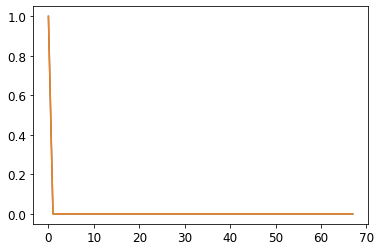

In [138]:
state_history,measurement_history = model_predict(data,100, p_aproximate, 0.001)
print(tf.shape(state_history))
print(measurement_history)
plt.plot(state_history)
plt.plot(measurement_history)

In [23]:
data = tf.convert_to_tensor(data1, dtype=tf.float32)
x_out = model.sample( data, n_samples = 1, to_numpy=True, training=False)

In [25]:

print(x_out.shape)
print(x_out)
#print(x_out[:,:,0])
#print(x_out[:,:,0].shape)
print(type(x_out[:,:,0]))

#x1 = tensor(x_out[:,:,0], dtype=torch.int32)
#print(type(x1))

(1, 168, 5)
[[[1.1437329  2.80306    0.07648166 0.02445604 1.4476515 ]
  [1.7046279  3.3379712  0.08187961 0.01852885 1.2813424 ]
  [0.84950036 2.7281597  0.05118615 0.03335572 1.4884901 ]
  [1.3076849  2.2073493  0.07208852 0.02115667 1.6288733 ]
  [1.3770174  3.3796215  0.06482442 0.02582967 1.4502622 ]
  [1.4413298  3.3844807  0.09796275 0.03153749 1.4316965 ]
  [1.5863456  2.8444643  0.08009084 0.03540692 1.6700604 ]
  [1.6512973  2.713461   0.08394083 0.02655922 1.8625324 ]
  [1.2241662  2.2519853  0.08831566 0.02779531 1.5852257 ]
  [0.7671663  3.6484466  0.08918194 0.03344413 1.3083689 ]
  [1.4786134  3.1590693  0.06941566 0.02397681 1.0062926 ]
  [0.87145305 3.0773187  0.06164063 0.00820375 1.8955708 ]
  [1.0084798  2.5181653  0.06332008 0.01998394 1.1021793 ]
  [0.93857855 3.0999153  0.07417395 0.03062506 1.1721596 ]
  [1.3207018  3.5942523  0.08255223 0.02917981 1.2143178 ]
  [1.3994989  3.1375456  0.04781338 0.03041194 1.4596244 ]
  [1.7837105  3.4996624  0.07123552 0.015874

In [18]:
print(data1.shape)
print(data2.shape)
print(data3.shape)
print(data4.shape)


data = np.vstack((data1,data2,data3))
print(data.shape)
print(theta_test.shape)
#obs_data = tf.convert_to_tensor(obs_data[:, :], dtype=tf.float32)

(168,)
(168,)
(168,)
(132,)
(3, 168)
(64, 5)


In [19]:
print(obs_data.shape)
print(theta_test[:3].shape)

plot_true_est_scatter(model, obs_data, theta_test[:3], n_samples_posterior, param_names[:5], 
                      figsize=(10, 3), filename='Ricker')
                      

NameError: name 'obs_data' is not defined

### Full posterior (visual inspection)

In [ ]:

plot_true_est_posterior(model, n_samples=n_samples_posterior, param_names=param_names, 
                        X_test=X_test[:4, :], theta_test=theta_test[:4, :], tight=True, figsize=(10, 4))




### Errors

In [ ]:
import argparse
import json
import numpy as np
import os
import pyro
import pyro.distributions as dist
import torch
from dataset import load_battery
import time

# title MCMC Batch Training w/ Regen
pyro.set_rng_seed(1)


def battery_model(length: int, noise_std: float):
    """Create the model of battery degradation."""

    # parameter priors
    param_a = torch.tensor(x_out[:,:,0], dtype=torch.int32)
    param_b = torch.tensor(x_out[:,:,1], dtype=torch.int32)

    poisson_rate = torch.tensor(x_out[:,:,2], dtype=torch.int32)
    #poisson_rate_int = poisson_rate.item()

    regen_gamma_beta = torch.tensor(x_out[:,:,3], dtype=torch.int32)
    regen_gamma_mu = torch.tensor(x_out[:,:,4], dtype=torch.int32)

    Ri = np.random.gamma(regen_gamma_beta.item(), regen_gamma_mu.item())

    state_history = torch.zeros((length,))
    measurement_history = torch.zeros((length,))
    for i in range(length):
        if i == 0:
            next_capacity = torch.tensor(1.0)
        elif i % round(1 / poisson_rate) == 0:
            next_capacity = (
                state_history[i - 1]
                - (param_a * param_b * i) / (10000 + (param_b * i) ** 2)
                + Ri
            )
        else:
            next_capacity = state_history[i - 1] - (param_a * param_b * i) / (
                10000 + (param_b * i) ** 2
            )

        next_observed = pyro.sample(
            f"meas_{i}", dist.Normal(next_capacity, torch.tensor(noise_std))
        )
        state_history[i] = next_capacity
        measurement_history[i] = next_observed

    return state_history, measurement_history


def conditioned_battery_model(
    model, measurement_history: torch.Tensor, noise_std: float
):
    return pyro.condition(
        model, data={f"meas_{i}": m for i, m in enumerate(measurement_history)}
    )(measurement_history.shape[0], noise_std)


'''
def main(args):
    if torch.cuda.is_available():
        torch.set_default_tensor_type(torch.Tensor().to("cuda").type())
    battery_data = load_battery(os.path.abspath(args.filename))
    print("MCMC")
    print(args)
    times = []
    for _ in range(args.timing_trials):
        # do MCMC with NUTS
        nuts_kernel = pyro.infer.NUTS(
            conditioned_battery_model, jit_compile=True, ignore_jit_warnings=True
        )
        mcmc = pyro.infer.MCMC(
            nuts_kernel,
            num_samples=args.samples,
            warmup_steps=args.burnin,
            num_chains=args.chains,
        )
        tic = time.time()
        mcmc.run(
            battery_model, torch.Tensor(battery_data[: args.train_cycles]), args.noise
        )
        toc = time.time()
        times.append(toc - tic)
        print(f"MCMC Time: {times[-1]:0.2f} s")
    times = np.array(times)
    print(f"Mean: {np.mean(times)}, Std: {np.std(times)}")
    print()'''




In [ ]:
print(x_out.shape)
#print(x_out)
#print(x_out[:,:,0])
#print(x_out[:,:,0].shape)
print(type(x_out[:,:,0]))

x1 = torch.tensor(x_out[:,:,0], dtype=torch.int32)
print(type(x1))

regen_gamma_beta = torch.tensor(x_out[:,:,3], dtype=torch.int32)
regen_gamma_mu = torch.tensor(x_out[:,:,4], dtype=torch.int32)

print(regen_gamma_beta)

In [ ]:
state_history,measurement_history = battery_model(length= 100, noise_std=0.75)
x_out,noise_std =  conditioned_battery_model(model, measurement_history, noise_std=0.75)


